# Predictive Maintenance 

Dataset taken from

http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv

PROJECT: Maintenance cost reduction through predictive techniques

BACKGROUND
A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

GOAL
You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict is called failure with binary value 0 for non-failure and 1 for failure.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.models  import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

%matplotlib inline
print('Done !!!')

Done !!!


In [5]:
import tensorflow as tf 
tf.test.gpu_device_name() 

'/device:GPU:0'

# Load Split and Scale Dataset

In [6]:
# load the dataset
file_dir = Path('/content/drive/My Drive/Data_Science/projects/predictive_maintenance/data')
# file_dir = Path('/Users/khan_m_a/Google Drive/Data_Science/projects/predictive_maintenance/data')


df_one_hot = pd.read_csv( file_dir / 'df_one_hot.csv', parse_dates = True, index_col = 'date',delimiter = ',')
print('Loaded Dateset')

Loaded Dateset


In [7]:
# split the dataset into test = 3 month, val, and train

split_date = '2015-08-02'

train = df_one_hot.loc[pd.to_datetime(df_one_hot.index) <= split_date]
test = df_one_hot.loc[pd.to_datetime(df_one_hot.index) >= split_date]
print(train.tail(3), test.tail(3))

X = train.drop('failure', axis = 1).values
y = train.failure.values

# make statify = y for imbalanced dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                              test_size = 0.2, stratify = y )

#convert test to numpy
X_test = test.drop('failure', axis = 1).values
y_test = test.failure.values 
print(X_train.shape, y_train.shape,X_val.shape, y_val.shape,X_test.shape, y_test.shape)
print('failures in train, val, and test are :', y_train.sum(), y_val.sum(), y_test.sum())
 

            failure   metric1  ...  dev__Z1F282ZV  dev__Z1F2PBHX
date                           ...                              
2015-08-02        0  97114408  ...              0              0
2015-08-02        0  72484128  ...              0              0
2015-08-02        0  43895984  ...              0              0

[3 rows x 1178 columns]             failure    metric1  ...  dev__Z1F282ZV  dev__Z1F2PBHX
date                            ...                              
2015-11-02        0   19029120  ...              0              0
2015-11-02        0  226953408  ...              0              0
2015-11-02        0   17572840  ...              0              0

[3 rows x 1178 columns]
(87495, 1177) (87495,) (21874, 1177) (21874,) (15456, 1177) (15456,)
failures in train, val, and test are : 79 20 7


In [8]:
# Apply standardization to X_train and X_test
# scaler = MinMaxScaler()
X_train_min = X_train.min()
X_train_max = X_train.max()
print('Before scaling', X_train[0:3], y[0:3])
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)
    
  
# check scaled 
print('Train scaled', X_train[0:3], y[0:3])
print('Val scaled', X_val[0:3], y[0:3])
print('Test scaled', X_test[0:3], y[0:3])

Before scaling [[223544272         0         0 ...         0         0         0]
 [157102712         0       318 ...         0         0         0]
 [178116280         0         0 ...         0         0         0]] [0 0 0]
Train scaled [[9.15637882e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.43493091e-01 0.00000000e+00 1.30252877e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.29564716e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]] [0 0 0]
Val scaled [[7.25357794e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.24959957e-01 0.00000000e+00 9.01120535e-07 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.37654354e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]] [0 0 0]
Test scaled [[1.43272169e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.20730622e-01 0.00000000e

# XGBoost Algo with class weight

In [ ]:
# https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

# Hyperparameter tuning of class weight

# model definition
# define grid
weights = [10, 100, 500, 1000]
param_grid = dict(scale_pos_weight=weights)

clf_xgb = XGBClassifier()

# cross evaluation prodedure
cv = RepeatedStratifiedKFold(n_splits = 5 ,
                             n_repeats = 1,random_state = 42)

# grid search
grid = GridSearchCV(estimator=clf_xgb, param_grid=param_grid,
                    cv=cv, scoring='roc_auc', refit = True)

# fit the model
grid_result = grid.fit(X_train, y_train)
# report the best configuration
print("Best: {} using {}" .format(grid_result.best_score_, grid_result.best_params_))



/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best: 0.8766289952561614 using {'scale_pos_weight': 100}


In [9]:

# model definition
clf_xgb = XGBClassifier(scale_pos_weight = 100,
                        max_depth = 3,min_child_weight =3)

# fit the model
clf_xgb.fit(X_train, y_train)

# cross evaluation prodedure
cv = RepeatedStratifiedKFold(n_splits = 5 ,
                             n_repeats = 1,random_state = 42)


In [10]:
#checkin ROC - AUC -Train
#https://scikit-learn.org/stable/modules/model_evaluation.html

scoring = ['f1','roc_auc','precision', 'recall']#'neg_log_loss', 'accuracy',  ]


scores_xgb = cross_validate(clf_xgb, X_train, y_train,scoring = scoring,
                            cv =cv)

# print results
print(' Scores are :',scores_xgb)
# print('Train neg log is ',scores_xgb['test_neg_log_loss'])
# print('Train accuracy is ',scores_xgb['test_accuracy'])
print('Train precision is ',scores_xgb['test_precision'])
print('Train recall is ',scores_xgb['test_recall'])
print('Train ROC is ',scores_xgb['test_roc_auc'])
print('Train f1 score is ',scores_xgb['test_f1'])

 Scores are : {'fit_time': array([143.56428432, 144.44717145, 144.45895362, 144.47867107,
       145.11562228]), 'score_time': array([0.52712655, 0.43151283, 0.42414141, 0.429672  , 0.43923235]), 'test_f1': array([0.0397351 , 0.10344828, 0.11851852, 0.10687023, 0.04      ]), 'test_roc_auc': array([0.93235339, 0.91798104, 0.91997583, 0.88371561, 0.83611759]), 'test_precision': array([0.02205882, 0.06      , 0.06722689, 0.06086957, 0.02238806]), 'test_recall': array([0.2   , 0.375 , 0.5   , 0.4375, 0.1875])}
Train precision is  [0.02205882 0.06       0.06722689 0.06086957 0.02238806]
Train recall is  [0.2    0.375  0.5    0.4375 0.1875]
Train ROC is  [0.93235339 0.91798104 0.91997583 0.88371561 0.83611759]
Train f1 score is  [0.0397351  0.10344828 0.11851852 0.10687023 0.04      ]


In [11]:
#checkin ROC - AUC -Val

scores_xgb_val = cross_validate(clf_xgb, X_val, y_val,scoring = scoring,
                          cv =cv, n_jobs = -1)

# print results
print(' Scores are :',scores_xgb_val)
# print('Val neg log is ',scores_xgb_val['test_neg_log_loss'])
# print('Val accuracy is ',scores_xgb_val['test_accuracy'])
print('Val precision is ',scores_xgb_val['test_precision'])
print('Val recall is ',scores_xgb_val['test_recall'])
print('Val ROC is ',scores_xgb_val['test_roc_auc'])
print('Val f1 score is ',scores_xgb['test_f1'])

 Scores are : {'fit_time': array([53.76725912, 53.89704251, 52.69278002, 52.53470588, 35.23858213]), 'score_time': array([0.16123533, 0.19287038, 0.1563952 , 0.15460277, 0.12036324]), 'test_f1': array([0.        , 0.2       , 0.16666667, 0.16666667, 0.        ]), 'test_roc_auc': array([0.8148307 , 0.90033745, 0.99496683, 0.78277282, 0.63143593]), 'test_precision': array([0.        , 0.16666667, 0.125     , 0.125     , 0.        ]), 'test_recall': array([0.  , 0.25, 0.25, 0.25, 0.  ])}
Val precision is  [0.         0.16666667 0.125      0.125      0.        ]
Val recall is  [0.   0.25 0.25 0.25 0.  ]
Val ROC is  [0.8148307  0.90033745 0.99496683 0.78277282 0.63143593]
Val f1 score is  [0.0397351  0.10344828 0.11851852 0.10687023 0.04      ]


In [12]:
#checkin ROC - AUC -Test


scores_xgb_te = cross_validate(clf_xgb, X_test, y_test,scoring = scoring,
                          cv =cv, n_jobs = -1)

# print results
print(' Scores are :',scores_xgb_te)
# print('Test neg log is ',scores_xgb_te['test_neg_log_loss'])
# print('Test accuracy is ',scores_xgb_te['test_accuracy'])
print('Test precision is ',scores_xgb_te['test_precision'])
print('Test recall is ',scores_xgb_te['test_recall'])
print('Test ROC is ',scores_xgb_te['test_roc_auc'])
print('Test f1 score is ',scores_xgb['test_f1'])

 Scores are : {'fit_time': array([39.71748662, 38.72204399, 37.55166602, 37.44056654, 25.63236761]), 'score_time': array([0.09814548, 0.10497499, 0.10549712, 0.10525155, 0.07380104]), 'test_f1': array([0., 0., 0., 0., 0.]), 'test_roc_auc': array([0.73487055, 0.48171521, 0.99158576, 0.31909385, 0.50258983]), 'test_precision': array([0., 0., 0., 0., 0.]), 'test_recall': array([0., 0., 0., 0., 0.])}
Test precision is  [0. 0. 0. 0. 0.]
Test recall is  [0. 0. 0. 0. 0.]
Test ROC is  [0.73487055 0.48171521 0.99158576 0.31909385 0.50258983]
Test f1 score is  [0.0397351  0.10344828 0.11851852 0.10687023 0.04      ]


# ROC Curves

In [13]:
# ROC caculation
pred_rf_tr_proba = clf_xgb.predict_proba(X_train)
pred_rf_val_proba = clf_xgb.predict_proba(X_val)
pred_rf_te_proba = clf_xgb.predict_proba(X_test)

pred_rf_tr_proba[0:10]
pred_rf_val_proba[0:10]
pred_rf_te_proba[0:10]


#only the second column is needed
pred_rf_tr_proba_1 = [p[1] for p in pred_rf_tr_proba]
pred_rf_val_proba_1 = [p[1] for p in pred_rf_val_proba]
pred_rf_te_proba_1 = [p[1] for p in pred_rf_te_proba]


roc_acc_rf_tr = roc_auc_score( y_train, pred_rf_tr_proba_1)
roc_acc_rf_val = roc_auc_score( y_val, pred_rf_val_proba_1)
roc_acc_rf_te = roc_auc_score( y_test, pred_rf_te_proba_1)
print('Train ROC score is ', roc_acc_rf_tr)
print('val ROC score is ', roc_acc_rf_val)
print('Test ROC score is ', roc_acc_rf_te)

Train ROC score is  0.9951423167325623
val ROC score is  0.8347499313626795
Test ROC score is  0.9264214974616942


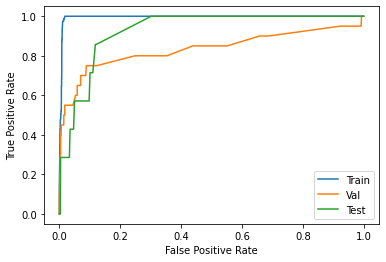

In [14]:
# drawing ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

lr_fpr_rf_tr, lr_tpr_rf_tr, _ = roc_curve(y_train, pred_rf_tr_proba_1)
lr_fpr_rf_val, lr_tpr_rf_val, _ = roc_curve(y_val, pred_rf_val_proba_1)
lr_fpr_rf_te, lr_tpr_rf_te, _ = roc_curve(y_test, pred_rf_te_proba_1)
plt.plot(lr_fpr_rf_tr, lr_tpr_rf_tr, label = 'Train')
plt.plot(lr_fpr_rf_val, lr_tpr_rf_val, label = 'Val')
plt.plot(lr_fpr_rf_te, lr_tpr_rf_te, label = 'Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Confusion Matrix

In [15]:
cm_prob_threshold = 0.5

In [16]:

pred_rf_tr = clf_xgb.predict(X_train)
pred_rf_val = clf_xgb.predict(X_val)
pred_rf_te = clf_xgb.predict(X_test)

In [17]:
print('Train Accuracy Score - ',accuracy_score(pred_rf_tr, y_train))
print('Test Accuracy Score - ',accuracy_score(pred_rf_val, y_val))
print('Test Accuracy Score - ',accuracy_score(pred_rf_te, y_test))

Train Accuracy Score -  0.9927767300988628
Test Accuracy Score -  0.993096827283533
Test Accuracy Score -  0.9762551759834368


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     86848
           1       0.59      0.07      0.13       647

    accuracy                           0.99     87495
   macro avg       0.79      0.54      0.56     87495
weighted avg       0.99      0.99      0.99     87495



Text(0.5, 15.0, 'Predicted label')

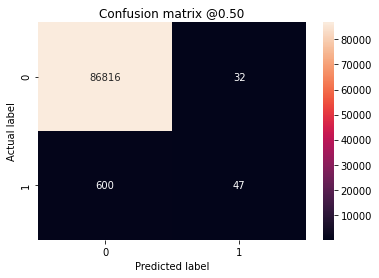

In [18]:
# confusion matrix for train
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''

conf_matrix_rf_tr = confusion_matrix(pred_rf_tr >cm_prob_threshold, y_train )

# print(conf_matrix_rf_tr)

conf_matrix_rf_report_tr = classification_report(pred_rf_tr, y_train )
print(conf_matrix_rf_report_tr)
sns.heatmap(conf_matrix_rf_tr, annot=True, fmt = 'd')
plt.title('Confusion matrix @{:.2f}'.format(cm_prob_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     21725
           1       0.45      0.06      0.11       149

    accuracy                           0.99     21874
   macro avg       0.72      0.53      0.55     21874
weighted avg       0.99      0.99      0.99     21874



Text(0.5, 15.0, 'Predicted label')

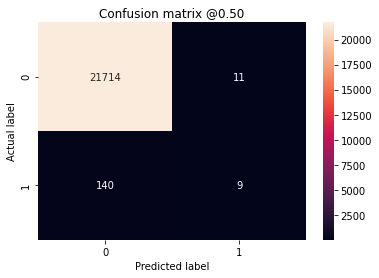

In [19]:
# confusion matrix for Val
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''

conf_matrix_rf_val = confusion_matrix(pred_rf_val >cm_prob_threshold, y_val )

# print(conf_matrix_rf_tr)

conf_matrix_rf_report_val = classification_report(pred_rf_val, y_val )
print(conf_matrix_rf_report_val)
sns.heatmap(conf_matrix_rf_val, annot=True, fmt = 'd')
plt.title('Confusion matrix @{:.2f}'.format(cm_prob_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

[[15087     5]
 [  362     2]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     15092
           1       0.29      0.01      0.01       364

    accuracy                           0.98     15456
   macro avg       0.63      0.50      0.50     15456
weighted avg       0.96      0.98      0.96     15456



Text(0.5, 15.0, 'Predicted label')

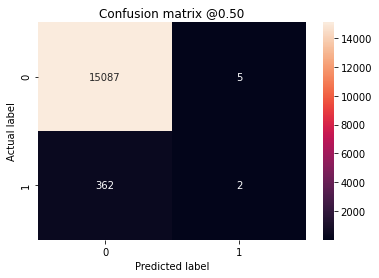

In [20]:
# confusion matrix for test
'''
                    Predicted
                  0          1
        0         TN         FP
Actual 
        1         FN         TP
'''

conf_matrix_rf_te = confusion_matrix(pred_rf_te>cm_prob_threshold, y_test )

print(conf_matrix_rf_te)

conf_matrix_rf_report = classification_report(pred_rf_te, y_test )
print(conf_matrix_rf_report)
sns.heatmap(conf_matrix_rf_te, annot=True, fmt = 'd')
plt.title('Confusion matrix @{:.2f}'.format(cm_prob_threshold))
plt.ylabel('Actual label')
plt.xlabel('Predicted label')